### Business Case 3 

#### Market Basket Analysis Exptected Uutcomes:
- Which types of products should have an extended amount of product offerings?
- Which types of products can be seen as substitutes?
- Which items are complementary?

# RULES USING ALL PRODUCTS

In [63]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import networkx as nx
from algorithmx import jupyter_canvas

In [69]:
# Import order product dataset
df = pd.read_csv('order_products.csv', usecols=['order_id', 'product_id'])

# Import product label mapping
products = pd.read_csv('products.csv')

# Merge product labels
df = pd.merge(df, products, how='left', on='product_id').\
    drop(["product_id", "department_id"], axis=1)

# Show dataframe
df

,order_id,product_name
0,10,fresh fruits
1,10,fresh vegetables
2,10,fresh herbs
3,10,fresh fruits
4,10,fresh vegetables
...,...,...
2019496,3420578,asian foods
2019497,3420578,fresh herbs
2019498,3420693,ice cream ice
2019499,3420693,ice cream ice


#### 1. Pivot Table 

In [70]:
# Pivot the data - lines as orders and products as columns
pt = pd.pivot_table(df, index='order_id', columns='product_name', 
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
# Show dataframe
pt

product_name,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
order_id,,,,,,,,,,,,,,,,,,,,,
10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3420991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3421019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3421027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### 2. Frequent Items

In [71]:
# Compute frequent items using the Apriori algorithm
frequent_itemsets = apriori(pt, min_support=0.03, use_colnames=True)

# Show dataframe
frequent_itemsets

,support,itemsets
0,0.043330,(asian foods)
1,0.045355,(baby food formula)
2,0.076635,(baking ingredients)
3,0.163865,(bread)
4,0.067765,(breakfast bakery)
...,...,...
392,0.032215,"(milk, packaged cheese, fresh vegetables, pack..."
393,0.036455,"(milk, yogurt, fresh vegetables, packaged vege..."
394,0.038635,"(packaged cheese, yogurt, fresh vegetables, pa..."
395,0.032845,"(fresh vegetables, milk, fresh fruits, package..."


In [72]:
# Create new support dataframe for two products only
frequent_itemsets_two = apriori(pt, min_support=0.03, use_colnames=True,  max_len = 2)

# Show dataframe
frequent_itemsets_two

,support,itemsets
0,0.043330,(asian foods)
1,0.045355,(baby food formula)
2,0.076635,(baking ingredients)
3,0.163865,(bread)
4,0.067765,(breakfast bakery)
...,...,...
240,0.032250,"(refrigerated, water seltzer sparkling water)"
241,0.047175,"(yogurt, refrigerated)"
242,0.037075,"(soy lactosefree, water seltzer sparkling water)"
243,0.058195,"(soy lactosefree, yogurt)"


#### 3. Assosiation Rules

#### 3.1. Confidence

The **confidence** measures how often the <code>consequent</code> appears in transactions that contain the<code>antecedent</code>.

In [73]:
# Generate the association rules - by confidence

# Compute all association rules for frequent_itemsets
rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.50)

# Sort values
rulesConfidence.sort_values(by='confidence', ascending=False, inplace=True)

# Show dataframe
rulesConfidence.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
322,"(fresh herbs, fresh fruits, packaged vegetable...",(fresh vegetables),0.043490,0.444360,0.039660,0.911934,2.052241,0.020335,6.309343
395,"(milk, yogurt, fresh vegetables, packaged vege...",(fresh fruits),0.036455,0.555995,0.032845,0.900974,1.620471,0.012576,4.483713
401,"(packaged cheese, yogurt, fresh vegetables, pa...",(fresh fruits),0.038635,0.555995,0.034565,0.894655,1.609106,0.013084,4.214775
258,"(fresh herbs, packaged vegetables fruits)",(fresh vegetables),0.052535,0.444360,0.046980,0.894261,2.012470,0.023636,5.254824
172,"(fresh herbs, fresh fruits)",(fresh vegetables),0.070135,0.444360,0.061815,0.881372,1.983463,0.030650,4.683872


#### 3.2.Lift

The **lift** measures the sales increase of the <code>consequent</code> when the<code>antecedent</code> is bought.
- **lift** = 1 suggests no relationship between the products
- **lift** > 1 suggests a positive relationship between the products
- **lift** < 1 suggests a negative relationship between the products (products are substitutes)

In [74]:
# Generate the association rules - by lift

# Compute all association rules for frequent_itemsets
rulesLift = association_rules(frequent_itemsets, metric="lift", min_threshold=1.5)

# Sort values
rulesLift.sort_values(by='lift', ascending=False, inplace=True)

# Show datafrmae
rulesLift.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
803,"(yogurt, fresh vegetables)","(packaged cheese, fresh fruits, packaged veget...",0.144660,0.090715,0.034565,0.238940,2.633959,0.021442,1.194761
798,"(packaged cheese, fresh fruits, packaged veget...","(yogurt, fresh vegetables)",0.090715,0.144660,0.034565,0.381028,2.633959,0.021442,1.381873
767,"(milk, fresh fruits, packaged vegetables fruits)","(yogurt, fresh vegetables)",0.087450,0.144660,0.032845,0.375586,2.596337,0.020194,1.369828
774,"(yogurt, fresh vegetables)","(milk, fresh fruits, packaged vegetables fruits)",0.144660,0.087450,0.032845,0.227050,2.596337,0.020194,1.180606
808,"(yogurt, packaged vegetables fruits)","(fresh fruits, fresh vegetables, packaged cheese)",0.127910,0.104570,0.034565,0.270229,2.584193,0.021189,1.227001


#### 4. Complementary Products

In [110]:
# Compute association rules for frequent_itemsets
rulesConfidence_two = association_rules(frequent_itemsets_two, metric="confidence", min_threshold=0.50)

# High Confidence and high Lift - complementary products
complementary_p = rulesConfidence_two[(rulesConfidence_two['lift'] > 1.3)].sort_values('lift', ascending=False)

complementary_p 

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
65,(fresh herbs),(fresh vegetables),0.093005,0.444360,0.078655,0.845707,1.903203,0.037327,3.601205
10,(canned jarred vegetables),(fresh vegetables),0.071890,0.444360,0.055055,0.765823,1.723429,0.023110,2.372733
13,(canned meals beans),(fresh vegetables),0.069705,0.444360,0.050435,0.723549,1.628295,0.019461,2.009906
81,(spices seasonings),(fresh vegetables),0.052165,0.444360,0.036660,0.702770,1.581533,0.013480,1.869394
66,(fresh herbs),(packaged vegetables fruits),0.093005,0.365415,0.052535,0.564862,1.545810,0.018550,1.458354
24,(dry pasta),(fresh vegetables),0.070055,0.444360,0.047235,0.674256,1.517364,0.016105,1.705756
32,(fresh dips tapenades),(packaged vegetables fruits),0.098205,0.365415,0.053785,0.547681,1.498791,0.017899,1.402959
85,(frozen produce),(packaged vegetables fruits),0.122580,0.365415,0.066985,0.546459,1.495449,0.022192,1.399180
79,(soup broth bouillon),(fresh vegetables),0.083365,0.444360,0.055380,0.664308,1.494976,0.018336,1.655206
14,(canned meals beans),(packaged vegetables fruits),0.069705,0.365415,0.037670,0.540420,1.478922,0.012199,1.380794


#### 5. Substitute Products

In [106]:
# Generate the association rules - by lift < 1

# Compute all association rules for frequent_itemsets
rulesLift_substitute = association_rules(frequent_itemsets, metric="lift", min_threshold=0.0)

# Sort values
rulesLift_substitute.sort_values(by='lift', ascending=True, inplace=True)

# Filter values above 1 and show the dataframe
rulesLift_substitute[rulesLift_substitute['lift']<1]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
203,(fresh fruits),(soft drinks),0.555995,0.087310,0.039585,0.071197,0.815447,-0.008959,0.982652
202,(soft drinks),(fresh fruits),0.087310,0.555995,0.039585,0.453384,0.815447,-0.008959,0.812280
196,(fresh fruits),(paper goods),0.555995,0.063575,0.032090,0.057716,0.907847,-0.003257,0.993782
197,(paper goods),(fresh fruits),0.063575,0.555995,0.032090,0.504758,0.907847,-0.003257,0.896542
266,(water seltzer sparkling water),(fresh vegetables),0.193005,0.444360,0.083355,0.431880,0.971915,-0.002409,0.978033
267,(fresh vegetables),(water seltzer sparkling water),0.444360,0.193005,0.083355,0.187584,0.971915,-0.002409,0.993328
316,(milk),(water seltzer sparkling water),0.243325,0.193005,0.046610,0.191555,0.992485,-0.000353,0.998206
317,(water seltzer sparkling water),(milk),0.193005,0.243325,0.046610,0.241496,0.992485,-0.000353,0.997589


#### 5. Market Basket Analysis Visualizations

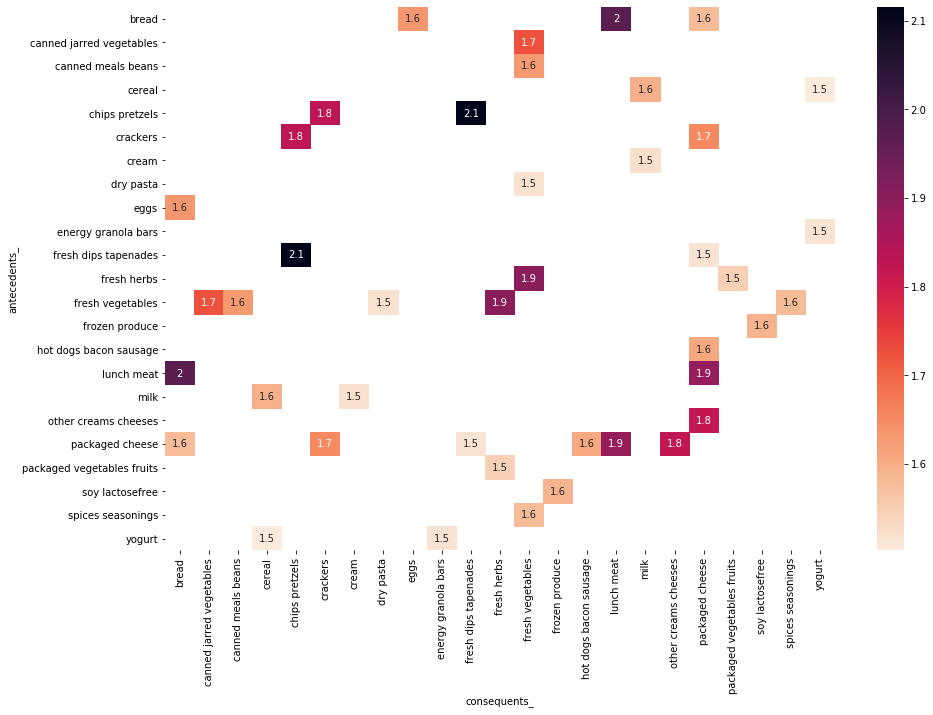

In [77]:
# Create visualization for the lifts for 

# Create column with the number of the left hand side items
rulesLift['lhs items'] = rulesLift['antecedents'].apply(lambda x:len(x) )

# Create column with the number of the right hand side items
rulesLift['rhs items'] = rulesLift['consequents'].apply(lambda x:len(x) )

# Replace frozen sets with strings
rulesLift['antecedents_'] = rulesLift['antecedents'].apply(lambda a: ','.join(list(a)))
rulesLift['consequents_'] = rulesLift['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rulesLift[(rulesLift['lhs items']==1) & (rulesLift['rhs items']==1)].pivot(index = 'antecedents_', 
                                                                                   columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pivot, annot = True, cmap=("rocket_r"))
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [295]:
# Create two columns with the antecedent and consequent products as strings
complementary_p['lhs products'] = complementary_p['antecedents'].apply(lambda a: ','.join(list(a)))
complementary_p['rhs products'] = complementary_p['consequents'].apply(lambda a: ','.join(list(a)))

# Create a list with the unique products from the left hand side (antecedents) and right hand side (consequents)
nodes_graph = pd.Series(complementary_p['lhs products'])
nodes_graph = nodes_graph.append(pd.Series(complementary_p['rhs products']))
nodes_graph = nodes_graph.unique().tolist()

In [296]:
# function to create tuples containing the antecedent, consequent and lift for each rule (row) 
def directed_edges(row):
    edge_graph = (row['lhs products'], row['rhs products'], round(row['lift'], 2))
    return edge_graph    

In [297]:
# apply the function
complementary_p['edge'] = complementary_p.apply(lambda row: directed_edges(row), axis=1)

# save the new created column to a list
edges_graph = complementary_p['edge'].to_list()

In [298]:
# Remove duplicated rules if reversed rules
complementary_selected['sortedRow'] = [sorted([a,b]) for a,b in zip(complementary_selected['lhs products'], 
                                                                    complementary_selected['rhs products'])]
complementary_selected['sortedRow'] = complementary_selected['sortedRow'].astype(str)
complementary_selected.drop_duplicates(subset=['sortedRow'], inplace=True)

In [299]:
#  set directed Graph
G = nx.DiGraph()

# set nodes and directions
G.add_nodes_from(nodes_graph)
G.add_weighted_edges_from(edges_graph)

# set canvas
canvas = algorithmx.jupyter_canvas()
canvas.size((600, 600))
canvas.edgelayout('symmetric').edgelength(80)

# add and set the nodes to the canvas
canvas.nodes(G.nodes).add(shape='rect', size=(60, 12),  fixed=True)

# add and set the edges (the lines that conect the nodes) to the canvas
canvas.edges(G.edges).add(labels=lambda e: {0: {'text': G.edges[e]['weight']}}).directed(True)

# display graph
canvas

JupyterWidget(events=['{"attrs": {"size": [600, 600]}}', '{"attrs": {"edgelayout": "symmetric"}}', '{"attrs": …

# RULES USING ONLY THE SELECTED PRODUCTS

In [184]:
# list with selected products
selected_products = ['fresh fruits', 'fresh vegetables', 'packaged vegetables fruits', 'yogurt', 'packaged cheese', 'milk', 
                     'water seltzer sparkling water', 'chips pretzels', 'soy lactosefree', 'bread', 'refrigerated', 
                     'frozen produce', 'ice cream ice', 'crackers', 'eggs', 'lunch meat']

# filter the pivot table for the selected products
pt_selected = pt[selected_products]

In [185]:
# Create new support dataframe for two products only
frequent_itemsets_selected = apriori(pt_selected, min_support=0.03, use_colnames=True,  max_len = 2)

# Show dataframe
frequent_itemsets_selected

,support,itemsets
0,0.555995,(fresh fruits)
1,0.444360,(fresh vegetables)
2,0.365415,(packaged vegetables fruits)
3,0.263675,(yogurt)
4,0.230995,(packaged cheese)
...,...,...
100,0.030175,"(soy lactosefree, refrigerated)"
101,0.032885,"(soy lactosefree, frozen produce)"
102,0.030170,"(soy lactosefree, eggs)"
103,0.036510,"(bread, eggs)"


**CONFIDENCE**

In [189]:
# Generate the association rules - by confidence

# Compute association rules for frequent_itemsets
rulesConfidence_selected = association_rules(frequent_itemsets_selected, metric="confidence", min_threshold=0.50)

# Sort values
rulesConfidence_selected.sort_values(by='confidence', ascending=False, inplace=True)

# Show dataframe
rulesConfidence_selected.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(packaged vegetables fruits),(fresh fruits),0.365415,0.555995,0.269870,0.738530,1.328304,0.066701,1.698112
11,(frozen produce),(fresh fruits),0.122580,0.555995,0.089235,0.727974,1.309317,0.021081,1.632213
1,(fresh vegetables),(fresh fruits),0.444360,0.555995,0.317560,0.714646,1.285346,0.070498,1.555978
3,(yogurt),(fresh fruits),0.263675,0.555995,0.188225,0.713852,1.283919,0.041623,1.551664
14,(eggs),(fresh fruits),0.136490,0.555995,0.095325,0.698403,1.256131,0.019437,1.472179


**LIFT**

In [191]:
# Generate the association rules - by lift

# Compute all association rules for frequent_itemsets
rulesLift_selected = association_rules(frequent_itemsets_selected, metric="lift", min_threshold=1.5)

# Sort values
rulesLift_selected.sort_values(by='lift', ascending=False, inplace=True)

# Show datafrmae
rulesLift_selected.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
12,(bread),(lunch meat),0.163865,0.103890,0.033565,0.204833,1.971636,0.016541,1.126946
13,(lunch meat),(bread),0.103890,0.163865,0.033565,0.323082,1.971636,0.016541,1.235209
4,(lunch meat),(packaged cheese),0.103890,0.230995,0.045205,0.435124,1.883693,0.021207,1.361369
5,(packaged cheese),(lunch meat),0.230995,0.103890,0.045205,0.195697,1.883693,0.021207,1.114145
6,(chips pretzels),(crackers),0.169435,0.114970,0.035630,0.210287,1.829061,0.016150,1.120698


**SUBSTITUTE PRODUCTS**

In [193]:
# Generate the association rules - by lift < 1

# Compute all association rules for frequent_itemsets
substitute_selected = association_rules(frequent_itemsets_selected, metric="lift", min_threshold=0.0)

# Sort values
substitute_selected.sort_values(by='lift', ascending=True, inplace=True)

# Filter values above 1 and show the dataframe
substitute_selected[substitute_selected['lift']<1]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
38,(water seltzer sparkling water),(fresh vegetables),0.193005,0.444360,0.083355,0.431880,0.971915,-0.002409,0.978033
39,(fresh vegetables),(water seltzer sparkling water),0.444360,0.193005,0.083355,0.187584,0.971915,-0.002409,0.993328
130,(milk),(water seltzer sparkling water),0.243325,0.193005,0.046610,0.191555,0.992485,-0.000353,0.998206
131,(water seltzer sparkling water),(milk),0.193005,0.243325,0.046610,0.241496,0.992485,-0.000353,0.997589


**COMPLEMENTARY PRODUCTS**

In [227]:
# High Confidence and high Lift - complementary products
complementary_selected = rulesConfidence_selected[(rulesConfidence_selected['lift'] > 1.3)].sort_values('lift', ascending=False)

complementary_selected

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
26,(frozen produce),(packaged vegetables fruits),0.122580,0.365415,0.066985,0.546459,1.495449,0.022192,1.399180
17,(packaged vegetables fruits),(fresh vegetables),0.365415,0.444360,0.234555,0.641887,1.444519,0.072179,1.551576
16,(fresh vegetables),(packaged vegetables fruits),0.444360,0.365415,0.234555,0.527849,1.444519,0.072179,1.344030
23,(frozen produce),(fresh vegetables),0.122580,0.444360,0.077750,0.634280,1.427400,0.023280,1.519303
28,(lunch meat),(packaged vegetables fruits),0.103890,0.365415,0.053225,0.512321,1.402024,0.015262,1.301234
24,(eggs),(fresh vegetables),0.136490,0.444360,0.084310,0.617701,1.390091,0.023659,1.453417
27,(eggs),(packaged vegetables fruits),0.136490,0.365415,0.068650,0.502967,1.376427,0.018775,1.276747
2,(packaged vegetables fruits),(fresh fruits),0.365415,0.555995,0.269870,0.738530,1.328304,0.066701,1.698112
19,(packaged cheese),(fresh vegetables),0.230995,0.444360,0.135850,0.588108,1.323494,0.033205,1.348994
11,(frozen produce),(fresh fruits),0.122580,0.555995,0.089235,0.727974,1.309317,0.021081,1.632213


**VISUALIZATION**

In [244]:
# Create two columns with the antecedent and consequent products as strings
complementary_selected['lhs products'] = complementary_selected['antecedents'].apply(lambda a: ','.join(list(a)))
complementary_selected['rhs products'] = complementary_selected['consequents'].apply(lambda a: ','.join(list(a)))

# Create a list with the unique products from the left hand side (antecedents) and right hand side (consequents)
nodes_graph = pd.Series(complementary_selected['lhs products'])
nodes_graph = nodes_graph.append(pd.Series(complementary_selected['rhs products']))
nodes_graph = nodes_graph.unique().tolist()

In [245]:
# Remove duplicated rules if reversed rules
complementary_selected['sortedRow'] = [sorted([a,b]) for a,b in zip(complementary_selected['lhs products'], 
                                                                    complementary_selected['rhs products'])]
complementary_selected['sortedRow'] = complementary_selected['sortedRow'].astype(str)
complementary_selected.drop_duplicates(subset=['sortedRow'], inplace=True)

In [289]:
# function to create tuples containing the antecedent, consequent and lift for each rule (row) 
def directed_edges(row):
    edge_graph = (row['lhs products'], row['rhs products'], round(row['lift'], 2))
    return edge_graph

In [290]:
# apply the function
complementary_selected['edge'] = complementary_selected.apply(lambda row: directed_edges(row), axis=1)

# save the new created column to a list
edges_weight_graph = complementary_selected['edge'].to_list()

In [291]:
# Remove duplicated rules if reversed rules
complementary_selected['sortedRow'] = [sorted([a,b]) for a,b in zip(complementary_selected['lhs products'], 
                                                                    complementary_selected['rhs products'])]
complementary_selected['sortedRow'] = complementary_selected['sortedRow'].astype(str)
complementary_selected.drop_duplicates(subset=['sortedRow'], inplace=True)

In [293]:
# GRAPH WITH WEIGHTED EDGES

#  set directed Graph
G = nx.DiGraph()

# set nodes and directions
G.add_nodes_from(nodes_graph)
G.add_weighted_edges_from(edges_weight_graph)

# set canvas
canvas = algorithmx.jupyter_canvas()
canvas.size((500, 500))
canvas.edgelayout('symmetric').edgelength(100)

# add and set the nodes to the canvas
canvas.nodes(G.nodes).add(shape='rect', size=(70, 12),  fixed=True)

# add and set the edges (the lines that conect the nodes) to the canvas
canvas.edges(G.edges).add(labels=lambda e: {0: {'text': G.edges[e]['weight']}}).directed(True)

# display graph
canvas

JupyterWidget(events=['{"attrs": {"size": [500, 500]}}', '{"attrs": {"edgelayout": "symmetric"}}', '{"attrs": …